<a href="https://colab.research.google.com/github/skywalker0803r/python-tutoring-materials/blob/main/%E8%AA%B2%E7%A8%8B/A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Categorical
from torch import optim
from torch import nn
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import warnings;warnings.simplefilter('ignore')

seed = 6
torch.manual_seed(seed)

# models

In [7]:
class critic(nn.Module):
    def __init__(self, input_dim):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,1)

    def forward(self,state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        return self.fc3(state)

In [8]:
class actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,output_dim)
    
    def forward(self, state):
        logits = F.relu(self.fc1(state))
        logits = F.relu(self.fc2(logits))
        return F.softmax(self.fc3(logits),dim = -1)

# agent

In [9]:
class A2CAgent:
    def __init__(self,env,gamma = 0.99 ,lr = 1e-3):
        
        # common paramters
        self.device = "cpu"
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.best_score = -np.inf
        
        # Hyper paramters
        self.gamma = gamma
        self.lr = lr
        
        # critic_net
        self.critic = critic(self.obs_dim).to(self.device)
        self.critic.apply(self._weights_init)
        
        # actor_net
        self.actor = actor(self.obs_dim,self.action_dim).to(self.device)
        self.actor.apply(self._weights_init)
        
        # optimizers
        self.critic_optimizer = optim.Adam(self.critic.parameters(),lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(),lr=lr)
            
    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias,0.01)
    
    def get_action(self,state):
        state = torch.FloatTensor([state]).to(self.device)
        probs = self.actor(state) # softmax probs
        dist = Categorical(probs) # Categorical distribution
        act = dist.sample() # smaple action from this Categorical distribution
        return act.detach().item()
    
    def get_value(self,state):
        state = torch.FloatTensor([state]).to(self.device)
        value = self.critic(state)
        return value.item()
    
    # 從"A2C論文"找到的計算"returns(G)"的方式
    def compute_returns(self,rewards):
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + self.gamma*G
            returns.insert(0,G)
        returns = np.array([i for i in returns]).ravel()
        return torch.FloatTensor(returns).to(self.device).view(-1, 1)
    
    def normalize(self,x):
        return (x - x.mean()) / x.std()
    
    def update(self,trajectory):
        
        print('update...')
        
        # get trajectory (取得一些遊戲歷程(state,action,rewards,next_state,done))
        state = torch.FloatTensor([sars[0] for sars in trajectory]).to(self.device)
        action = torch.LongTensor([sars[1] for sars in trajectory]).to(self.device).view(-1, 1)
        rewards = [sars[2] for sars in trajectory]
        next_state = torch.FloatTensor([sars[3] for sars in trajectory]).to(self.device)
        done = torch.FloatTensor([sars[4] for sars in trajectory]).to(self.device).view(-1, 1)  

        # 從A2C論文參考而來

        # calculate critic loss(計算critic loss)
        values = self.critic(state) #狀態價值
        returns = self.compute_returns(rewards) #實際遊戲的總分數
        advantage = returns.detach() - values #advantage = 實際遊戲的總分數 - 狀態價值
        critic_loss = advantage**2 # critic_loss  = advantage平方
            
        # calculate actor_loss(計算actor loss)
        logp = torch.gather(self.actor(state),1,action).log()
        # 取得actor在state下做的action的log機率稱之為logp
        # 將 -logp * advantage = actor_loss
        actor_loss = -logp * advantage.detach()
            
        # update critic (更新critic參數)
        self.critic_optimizer.zero_grad()
        critic_loss.mean().backward()
        self.critic_optimizer.step()
            
        # update actor (更新actor參數)
        self.actor_optimizer.zero_grad()
        actor_loss.mean().backward()
        self.actor_optimizer.step()
    
    def train(self,max_episodes):
        episode_rewards = []
        
        for episode in range(max_episodes):
            
            # initialize new game
            state = env.reset()
            trajectory = []
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                trajectory.append([state, action, reward, next_state, done])
                episode_reward += reward
                state = next_state
            
            # game over
            episode_rewards.append(episode_reward)
            self.best_score = max(self.best_score,episode_reward)
            print("Episode {} reward {} best {}".format(episode,episode_reward,self.best_score))
            if episode_reward < self.best_score:
                self.update(trajectory)
        
        return episode_rewards
    
    def play(self,max_episodes):
        episode_rewards = []
        
        for episode in range(max_episodes):
            
            # initialize new game
            state = env.reset()
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                self.env.render()
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state
            
            # game over
            print("Episode " + str(episode) + ": " + str(episode_reward))
            episode_rewards.append(episode_reward)
        
        return episode_rewards

In [10]:
import gym

env = gym.make("CartPole-v1")
env.seed(seed)

agent = A2CAgent(env)

history = agent.train(max_episodes=300)

Episode 0 reward 38.0 best 38.0
Episode 1 reward 15.0 best 38.0
update...
Episode 2 reward 25.0 best 38.0
update...
Episode 3 reward 10.0 best 38.0
update...
Episode 4 reward 86.0 best 86.0
Episode 5 reward 41.0 best 86.0
update...
Episode 6 reward 13.0 best 86.0
update...
Episode 7 reward 21.0 best 86.0
update...
Episode 8 reward 25.0 best 86.0
update...
Episode 9 reward 11.0 best 86.0
update...
Episode 10 reward 13.0 best 86.0
update...
Episode 11 reward 13.0 best 86.0
update...
Episode 12 reward 11.0 best 86.0
update...
Episode 13 reward 10.0 best 86.0
update...
Episode 14 reward 16.0 best 86.0
update...
Episode 15 reward 19.0 best 86.0
update...
Episode 16 reward 15.0 best 86.0
update...
Episode 17 reward 24.0 best 86.0
update...
Episode 18 reward 10.0 best 86.0
update...
Episode 19 reward 10.0 best 86.0
update...
Episode 20 reward 15.0 best 86.0
update...
Episode 21 reward 18.0 best 86.0
update...
Episode 22 reward 15.0 best 86.0
update...
Episode 23 reward 16.0 best 86.0
update..

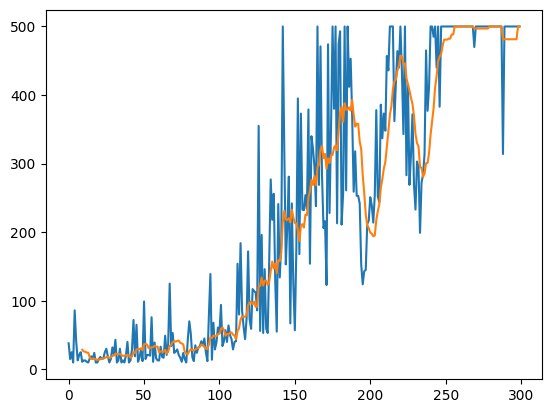

In [11]:
plt.plot(history)
plt.plot(pd.Series(history).rolling(10).mean())

# test

In [13]:
#history = agent.play(max_episodes=10)

In [14]:
#agent.env.close()